# Пркатикум по статистике

## Семинар : АБ-тестирование

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sps
import seaborn as sns
from tqdm import tqdm

### АА и AБ Тест 

Будем генерировать искусственные данные - функция умеет генерировать выборки с разными стратами и ковариатами

In [2]:
def generate_sample(
    n=1000,
    strata_probs=None,
    strata_params=None,
    covariates_params=None,
):
    data = pd.DataFrame()

    if strata_probs is None:
        data["Y"] = np.random.uniform(low=-1, high=1, size=n)
    else:
        new_low = np.array([-1] * n)
        new_high = np.array([1] * n)

        lows, highs = strata_params

        data[f'S'] = np.random.choice([x for x in range(len(strata_probs))], size=n, p=strata_probs)

        new_low = np.array(lows)[data[f'S']]
        new_high = np.array(highs)[data[f'S']]

        data["Y"] = np.random.uniform(low=new_low, high=new_high)

    if covariates_params is not None:
        for i, params in enumerate(covariates_params):
            data[f'X_{i}'] = data['Y'] + np.random.normal(loc=params[0], scale=params[1], size=n)

    return data

In [4]:
def add_effect(data, effect):
    data = data.assign(Y=data['Y'] + effect)
    return data

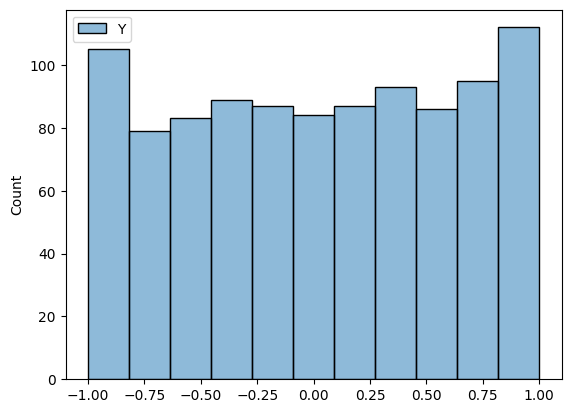

In [5]:
data = generate_sample()
sns.histplot(data)
plt.show()

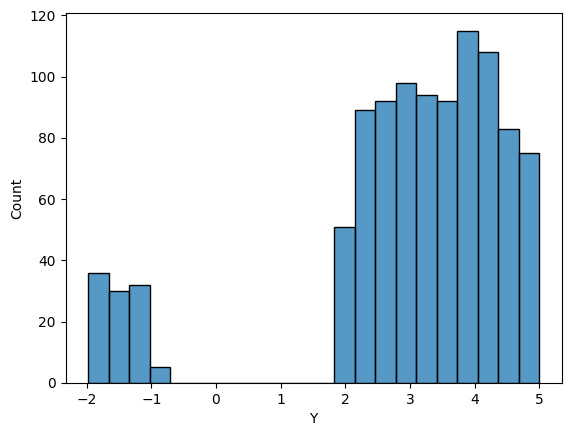

In [6]:
data = generate_sample(
    strata_probs=[0.1, 0.9],
    strata_params=
        [[-2, 2], 
         [-1, 5]],
)
sns.histplot(data['Y'])
plt.show()

In [7]:
data

,S,Y
0,1,4.377437
1,1,2.305341
2,1,3.848779
3,1,2.751099
4,1,2.610746
...,...,...
995,0,-1.283245
996,1,2.794306
997,1,3.207548
998,1,3.547591


In [8]:
def generate_two_samples_random(
    n=1000,
    effect=0,
    strata_probs=None,
    strata_params=None,
    covariates_params=None,
):
    sample = generate_sample(
        n=n,
        strata_probs=strata_probs,
        strata_params=strata_params,
        covariates_params=covariates_params
    )
    A, B = sample.iloc[:n // 2], sample.iloc[n // 2:]
    B = add_effect(B, effect)
    return [A, B]

Определим статистические тесты

In [ ]:
def ttest_factory(alternative: str):
    def ttest(A, B, equal_var=True) -> bool:
        test_res = sps.ttest_ind(A, B, alternative=alternative, equal_var=equal_var)
        return test_res.pvalue

    return ttest

def mannwhitneyu_factory(alternative: str):
    def mannwhitneyu(A, B, **kwargs) -> bool:
        test_res = sps.mannwhitneyu(A, B, alternative=alternative)
        return test_res.pvalue

    return mannwhitneyu

In [ ]:
def ab_test(
    n=1000,
    effect=0,
    strata_probs=None,
    strata_params=None,
    covariates_params=None,
    stat_test=ttest_factory(alternative='less')
):
    A, B = generate_two_samples_random(
        n=n,
        strata_probs=strata_probs,
        strata_params=strata_params,
        covariates_params=covariates_params,
        effect=effect
    )

    return stat_test(A['Y'], B['Y'], equal_var=True)

In [22]:
def plot_ci(alpha, pvals, rejects_num):
    plt.figure(figsize=(10, 4))

    plt.hist(
        pvals[pvals > alpha],
        bins=38, 
        color='lightgreen', 
        edgecolor='black'
    )
    plt.hist(
        pvals[pvals <= alpha],
        bins=2,
        color='red',
        edgecolor='black',
        label=f'FPR = {round(rejects_num / len(pvals) * 100, 1)}%'
    )
    plt.xlim((0, 1))

    plt.axvline(alpha, color='black', linewidth=2, label=f'$\\alpha$ = {alpha * 100}%')

    plt.legend(loc='upper right')

    plt.title("Распределение pvalue")

    plt.xlabel('pvalue')
    plt.ylabel('Частота')

    plt.show()

In [23]:
def aa_test(
    stat_test,
    alpha=0.05,
    n_samples=1000,
    test=ab_test,
    plot=True,
    **kwargs
):
    test_args = {
        'n': 1000,
        'effect': 0,
        "strata_probs": None,
        "strata_params": None,
        "covariates_params": None,
    }

    for key, value in kwargs.items():
        test_args[key] = value

    if plot:
        pvals = [test(**test_args, stat_test=stat_test) for _ in tqdm(range(n_samples))]
    else:
        pvals = [test(**test_args, stat_test=stat_test) for _ in range(n_samples)]

    pvals = np.array(pvals)

    rejects_num = (pvals < alpha).sum()

    if plot:
        plot_ci(alpha=alpha, pvals=pvals, rejects_num=rejects_num)

    return rejects_num / n_samples

Проведём АА-тест (без эффекта)

100%|██████████| 10000/10000 [00:32<00:00, 305.13it/s]


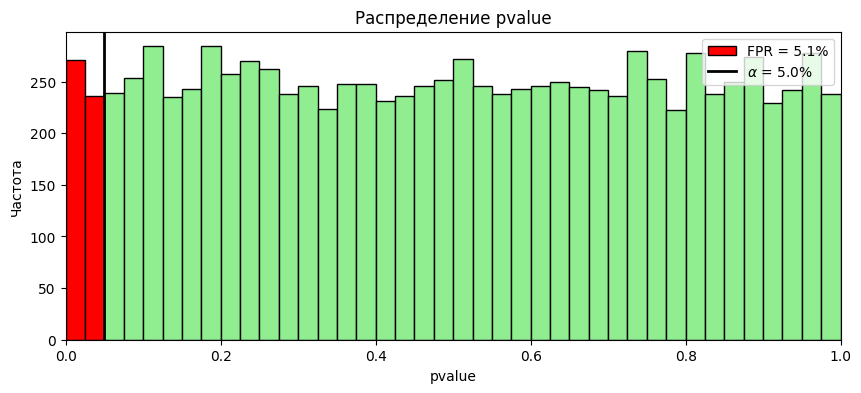

0.0507

In [24]:
aa_test(
    stat_test=ttest_factory(alternative='less'), 
    n_samples=10000
)

Теперь с эффектом 0.1 (AB-test)

100%|██████████| 10000/10000 [00:32<00:00, 311.53it/s]


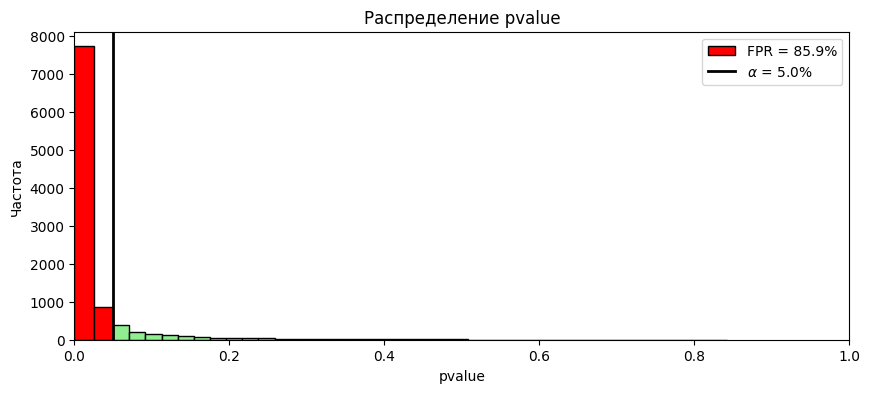

0.8592

In [25]:
aa_test(
    stat_test=ttest_factory(alternative='less'), 
    n_samples=10000,
    effect=0.1,
)

А теперь посмотрим на долю отвержений при разных значениях эффекта

In [33]:
def draw_power(
    effect_grid,
    n_samples=1000,
    test=ab_test,
    alternative='less',
    **kwargs
):
    plt.figure(figsize=(12, 8))

    probs_ttest = []
    probs_mann_whitney = []

    for effect in tqdm(effect_grid):
        prob_ttest = aa_test(
            effect=effect, 
            n_samples=n_samples, 
            test=test, 
            plot=False, 
            stat_test=ttest_factory(alternative=alternative), 
            **kwargs
        )
        prob_mann_whitney = aa_test(
            effect=effect, 
            n_samples=n_samples, 
            test=test, 
            plot=False, 
            stat_test=mannwhitneyu_factory(alternative=alternative), 
            **kwargs
        )
        
        probs_ttest.append(prob_ttest)
        probs_mann_whitney.append(prob_mann_whitney)

    plt.plot(effect_grid, probs_ttest, label="доля отвержений t-test")
    plt.plot(effect_grid, probs_mann_whitney, label="доля отвержений Манна-Уитни U-test")
    
    plt.axhline(0.05, color='red', linestyle='--', label=r'$\alpha = 0.05$')

    plt.xlabel('Эффект')
    plt.ylabel('Мощность теста')

    plt.legend()
    plt.title('Доля отвержений при разных значениях эффекта')

    plt.show()

100%|██████████| 25/25 [02:20<00:00,  5.61s/it]


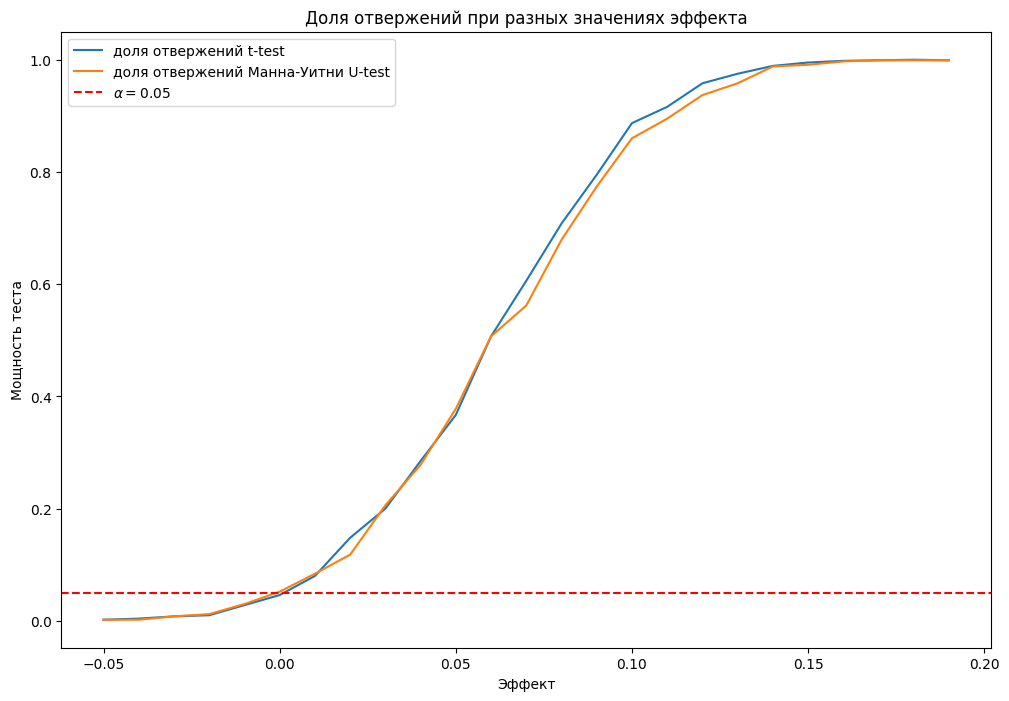

In [34]:
draw_power(np.arange(-0.05, 0.2, 0.01), n_samples=1000)

100%|██████████| 40/40 [03:56<00:00,  5.91s/it]


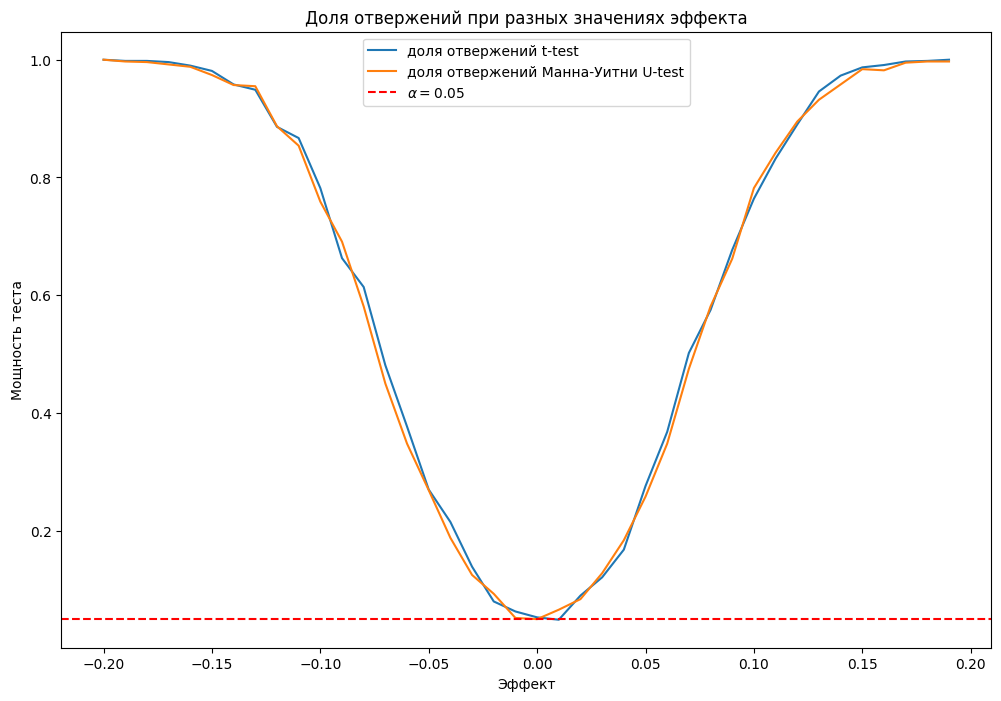

In [35]:
draw_power(np.arange(-0.2, 0.2, 0.01), n_samples=1000, alternative='two-sided')